## Input

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


#import lifelines library for survival analysis & regression
from lifelines import AalenAdditiveFitter, CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter, WeibullAFTFitter, WeibullFitter, LogNormalFitter, LogLogisticFitter, ExponentialFitter
from lifelines.utils import qth_survival_times, k_fold_cross_validation, find_best_parametric_model
from lifelines.calibration import survival_probability_calibration
from lifelines.plotting import qq_plot


#set standard options for dataframe viewing and plotting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.rcParams["figure.figsize"] = (15,5)
plt.style.use(["ggplot","seaborn-whitegrid"])

#ignore warnings for functions that will soon be outdated
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
###########INPUT CLEANED DATA###########

file = 'data.sas7bdat'

########################################

In [3]:
data = pd.read_sas(file, index='ID')

## Data Transformation

In [4]:
#Transform certain columns of dataframe into integers (mainly to remove .0)

liste = ['AGE', 'GENDER', 'HR', 'SYSBP', 'DIASBP', 'CVD', 'AFB', 'SHO', 'CHF' ,'AV3', 'MIORD', 'MITYPE', 'YEAR', 'LOS', 'DSTAT', 'LENFOL', 'FSTAT']

for i in liste:
    data[i] = data[i].astype('int64')

data.index = data.index.astype('int64')


### Data Viewing

In [5]:
data.shape

(500, 18)

In [6]:
data.head()

,AGE,GENDER,HR,SYSBP,DIASBP,BMI,CVD,AFB,SHO,CHF,AV3,MIORD,MITYPE,YEAR,LOS,DSTAT,LENFOL,FSTAT
ID,,,,,,,,,,,,,,,,,,
1,83,0,89,152,78,25.540510,1,1,0,0,0,1,0,1,5,0,2178,0
2,49,0,84,120,60,24.023979,1,0,0,0,0,0,1,1,5,0,2172,0
3,70,1,83,147,88,22.142900,0,0,0,0,0,0,1,1,5,0,2190,0
4,70,0,65,123,76,26.631870,1,0,0,1,0,0,1,1,10,0,297,1
5,70,0,63,135,85,24.412550,1,0,0,0,0,0,1,1,6,0,2131,0


For detailed description of columns see documentation.

## First Testing

Here we do a first testing on our data with the univariate survival model Kaplan Meier.

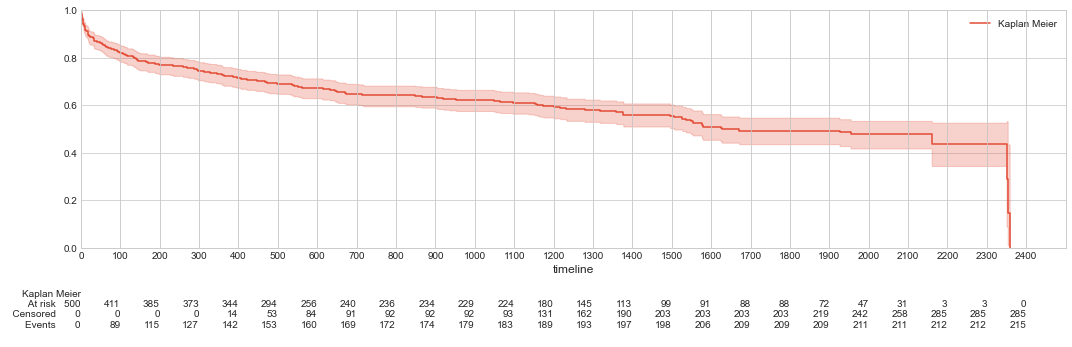

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(data['LENFOL'], event_observed=data['FSTAT'], label='Kaplan Meier') 

#customizing plot (also done in future plots)
plt.axis([0,2500,0,1])
plt.xticks(np.arange(0, 2500, step=100))
kmf.plot_survival_function(at_risk_counts=True)
plt.grid(b=True, which='both')

plt.savefig('Kaplan_Meier.svg', transparent=True, bbox_inches='tight')

This is the Nelson Aalen Model which is the corresponding Hazard for Kaplan Meier.

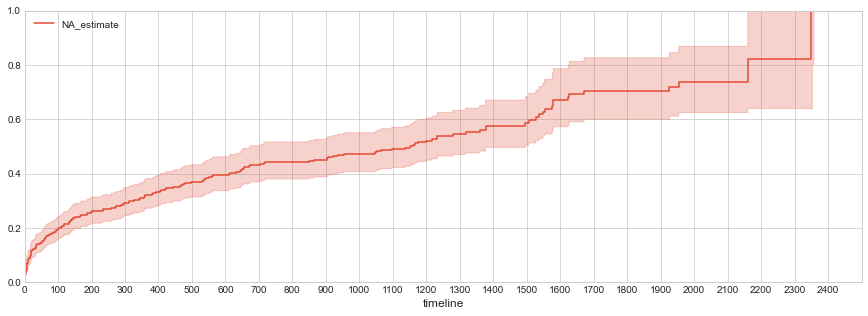

In [8]:
naf = NelsonAalenFitter()
naf.fit(data['LENFOL'],event_observed=data['FSTAT'])

naf.plot_cumulative_hazard()
plt.axis([0,2500,0,1])
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both');

## Descriptive Analysis

General overview about the data

In [9]:
data.describe()

,AGE,GENDER,HR,SYSBP,DIASBP,BMI,CVD,AFB,SHO,CHF,AV3,MIORD,MITYPE,YEAR,LOS,DSTAT,LENFOL,FSTAT
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,69.846000,0.400000,87.018000,144.704000,78.266000,26.613780,0.750000,0.156000,0.044000,0.310000,0.02200,0.342000,0.306000,1.984000,6.116000,0.07800,882.436000,0.430000
std,14.491456,0.490389,23.586231,32.294865,21.545293,5.405655,0.433446,0.363219,0.205301,0.462956,0.14683,0.474855,0.461291,0.790566,4.714127,0.26844,705.665133,0.495572
min,30.000000,0.000000,35.000000,57.000000,6.000000,13.045460,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000
25%,59.000000,0.000000,69.000000,123.000000,63.000000,23.223774,0.750000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,3.000000,0.00000,296.500000,0.000000
50%,72.000000,0.000000,85.000000,141.500000,79.000000,25.945925,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,5.000000,0.00000,631.500000,0.000000
75%,82.000000,1.000000,100.250000,164.000000,91.250000,29.391962,1.000000,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000,3.000000,7.000000,0.00000,1363.500000,1.000000
max,104.000000,1.000000,186.000000,244.000000,198.000000,44.838860,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,3.000000,47.000000,1.00000,2358.000000,1.000000


In [10]:
#Variance of used attributes
data.var()

AGE          210.002289
GENDER         0.240481
HR           556.310297
SYSBP       1042.958301
DIASBP       464.199643
BMI           29.221109
CVD            0.187876
AFB            0.131928
SHO            0.042148
CHF            0.214329
AV3            0.021559
MIORD          0.225487
MITYPE         0.212790
YEAR           0.624994
LOS           22.222990
DSTAT          0.072060
LENFOL    497963.280465
FSTAT          0.245591
dtype: float64

In [11]:
data.nunique()

AGE        66
GENDER      2
HR        105
SYSBP     133
DIASBP     97
BMI       411
CVD         2
AFB         2
SHO         2
CHF         2
AV3         2
MIORD       2
MITYPE      2
YEAR        3
LOS        27
DSTAT       2
LENFOL    395
FSTAT       2
dtype: int64

### Correlation Table & Matrix

In [12]:
data.corr()

,AGE,GENDER,HR,SYSBP,DIASBP,BMI,CVD,AFB,SHO,CHF,AV3,MIORD,MITYPE,YEAR,LOS,DSTAT,LENFOL,FSTAT
AGE,1.000000,0.274892,0.149137,-0.015599,-0.206044,-0.402484,0.159443,0.169050,0.090523,0.293591,0.054338,0.156484,-0.220474,-0.009661,0.068994,0.187005,-0.312208,0.486135
GENDER,0.274892,1.000000,0.115981,0.081517,-0.088236,-0.148578,0.131993,0.042754,0.003981,0.158888,-0.011133,0.030981,-0.152375,0.001034,0.107319,0.082206,-0.063674,0.148431
HR,0.149137,0.115981,1.000000,-0.006947,0.086745,-0.055788,-0.010340,0.102364,-0.048171,0.238808,-0.129156,0.083546,-0.181934,0.031183,0.107005,0.070044,-0.179739,0.259253
SYSBP,-0.015599,0.081517,-0.006947,1.000000,0.610916,0.121719,0.149319,-0.075669,-0.154903,-0.031515,-0.057791,0.017461,-0.095337,0.047773,0.017641,-0.176483,0.073307,-0.074674
DIASBP,-0.206044,-0.088236,0.086745,0.610916,1.000000,0.177371,0.015290,0.025417,-0.054753,-0.093069,-0.042396,-0.122323,0.125076,0.006251,0.045629,-0.141500,0.166732,-0.188289
BMI,-0.402484,-0.148578,-0.055788,0.121719,0.177371,1.000000,0.073024,-0.118545,-0.058418,-0.120548,-0.076024,-0.090315,0.101250,0.065174,-0.053005,-0.125764,0.192634,-0.277481
CVD,0.159443,0.131993,-0.010340,0.149319,0.015290,0.073024,1.000000,0.006365,0.011260,0.147304,0.023616,0.192296,-0.197950,0.040938,0.047567,0.012917,-0.048612,0.081633
AFB,0.169050,0.042754,0.102364,-0.075669,0.025417,-0.118545,0.006365,1.000000,0.149637,0.164702,0.048248,-0.042712,-0.010382,0.008710,0.203591,0.059934,-0.075755,0.149855
SHO,0.090523,0.003981,-0.048171,-0.154903,-0.054753,-0.058418,0.011260,0.149637,1.000000,0.151389,0.100784,-0.051885,0.111476,-0.020348,0.150015,0.410322,-0.123494,0.148516
CHF,0.293591,0.158888,0.238808,-0.031515,-0.093069,-0.120548,0.147304,0.164702,0.151389,1.000000,0.076356,0.118415,-0.050955,0.030006,0.172648,0.159803,-0.274633,0.378654


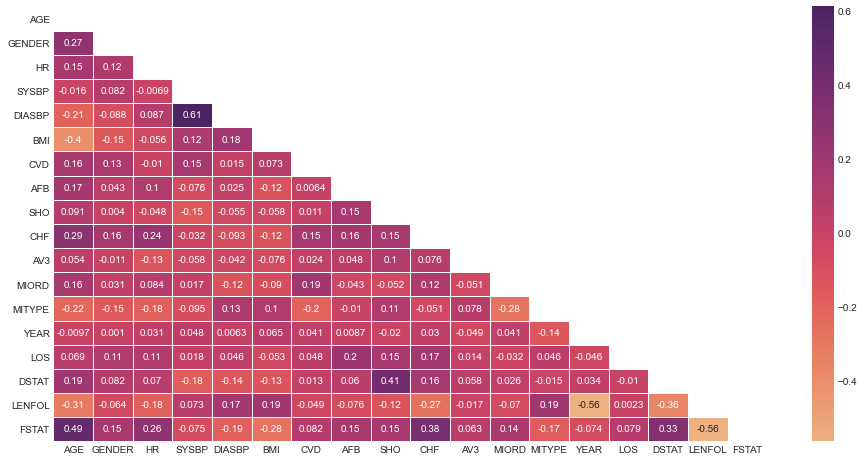

<Figure size 1080x360 with 0 Axes>

In [13]:
plt.figure(figsize = (16, 8))

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', linewidths = 1, cmap="flare")
plt.show()
plt.savefig('correlation.png')

We will filter out columns with high correlation
(i.e. SYSBP/DIASBP, YEAR/LENFOL, SHO/DSTAT, AGE/BMI).
Note that correlations with columns LENFOL or FSTAT will not be taken into account, as these are the target variables

### Transform certain columns into categories

In [14]:
categories = ['GENDER', 'CVD', 'AFB', 'SHO', 'CHF', 'AV3', 'MIORD', 'MITYPE']

for i in categories:
    data[i] = data[i].astype("category")

## Filter Data

In [15]:
data = data[['FSTAT', 'LENFOL', 'AGE', 'GENDER', 'HR', 'DIASBP', 'CHF']]

We filtererd out columns with high correlation (1 of each pair) & chose the 5 most interesting and significant attributes (+ the necessary columns for time and event)

### List number of unique values and plot distributions of every attribute

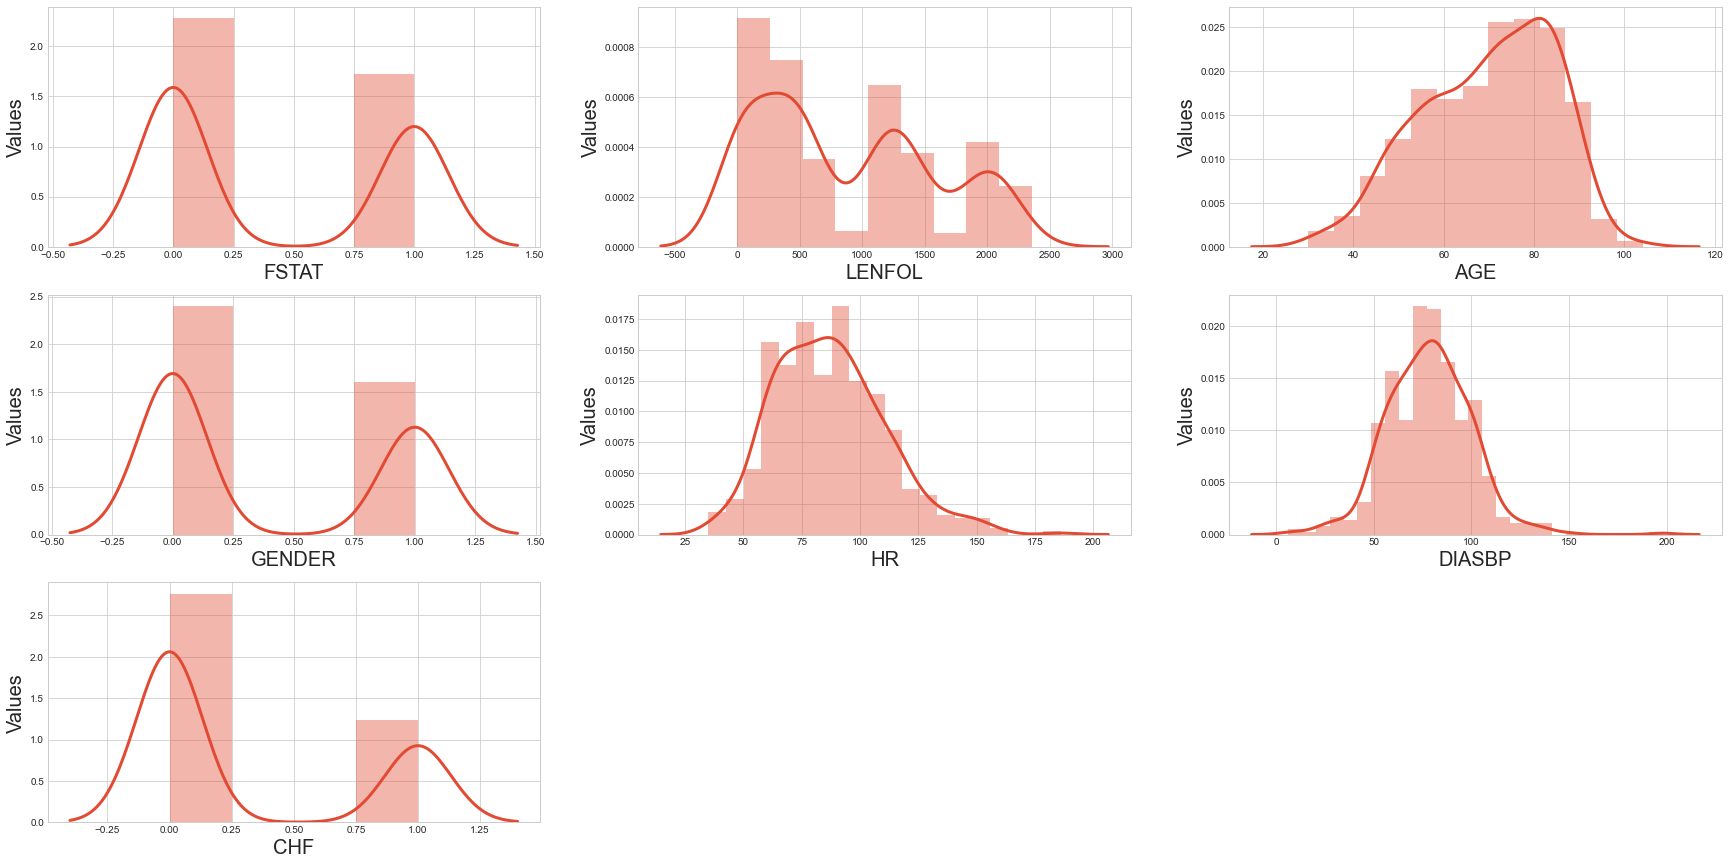

In [16]:
plt.figure(figsize=(30,15))
plotnumber=1

for column in data:
    if plotnumber<8:
        ax=plt.subplot(3,3,plotnumber)
        sns.distplot(data[column], kde_kws={"linewidth":3})
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Values',fontsize=20)
    plotnumber+=1
plt.show()


Plot Scatter Matrix to identify further relations between attributes (e.g. examine clusters)

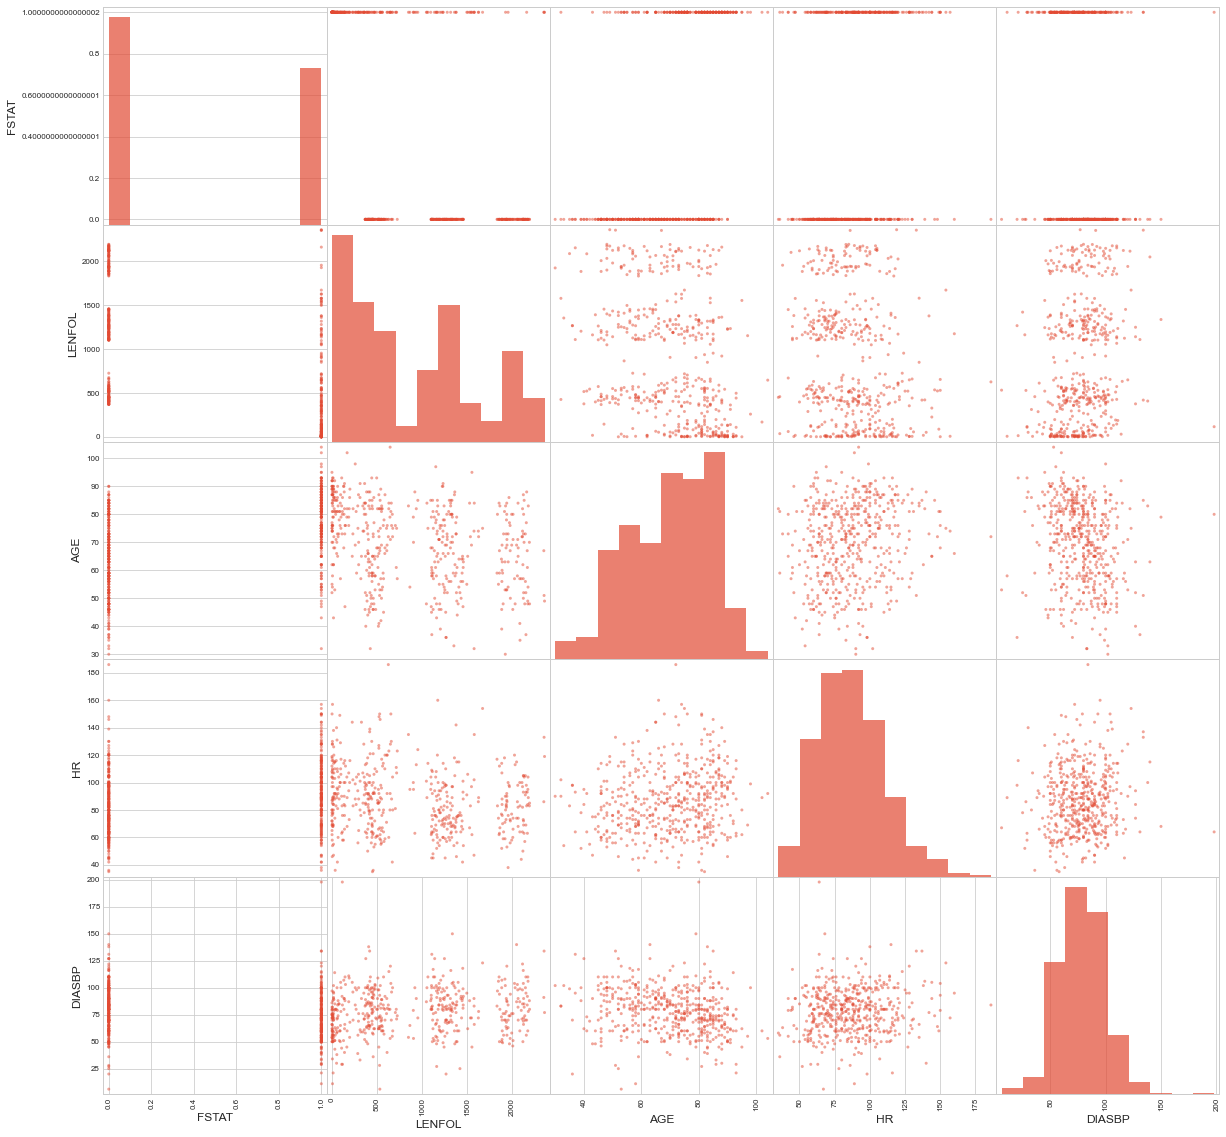

In [17]:
pd.plotting.scatter_matrix(data, figsize=(20,20), hist_kwds={"alpha":0.7});

You can see clusters on columns/rows related to the time attribute LENFOL, which means the data was collected in a regimented fashion. Overall the Variance remains the same over time.

## Model Selection

Our first approach is to use univariate parametric models which need a certain distribution of data (we already used the only non parametric univariate model: Kaplan Meier). Lifelines has the most important distributions implemented.
Lifelines also provides qqplots to help to graphically choose the right distribution

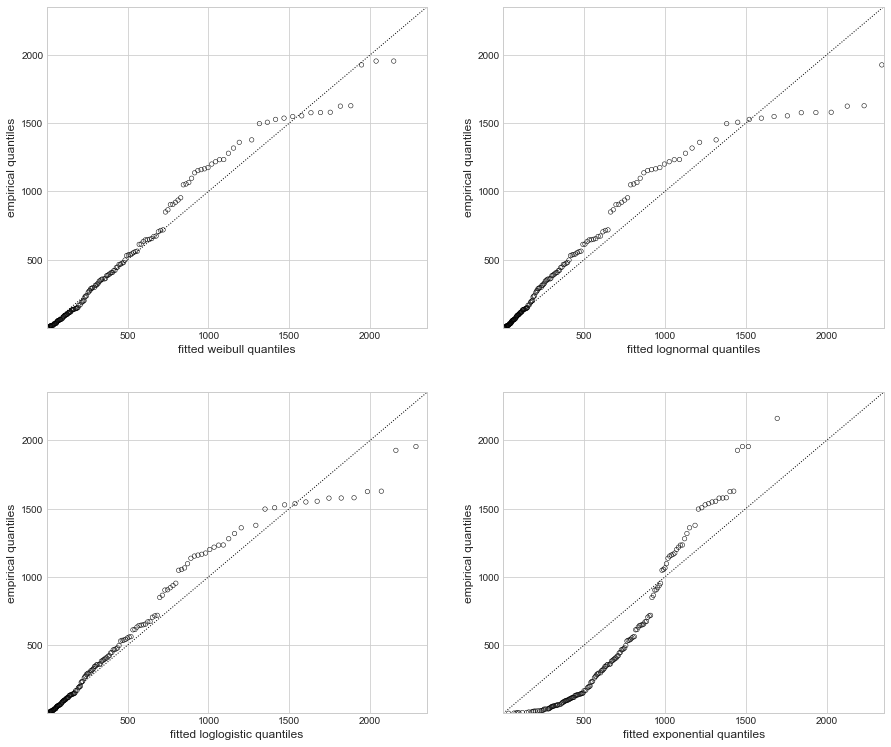

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(data['LENFOL'], data['FSTAT'])
    qq_plot(model, ax=axes[i])

The more the datapoints are on the line, the better the distribution is. Note that datapoints more to the right are allowed to spread more. Nevertheless, none of the plots below are as appropriate as we want them to. But for general testing we continued with the best model:

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 500 total observations, 285 right-censored observations>
3506.4392661978636


<AxesSubplot:>

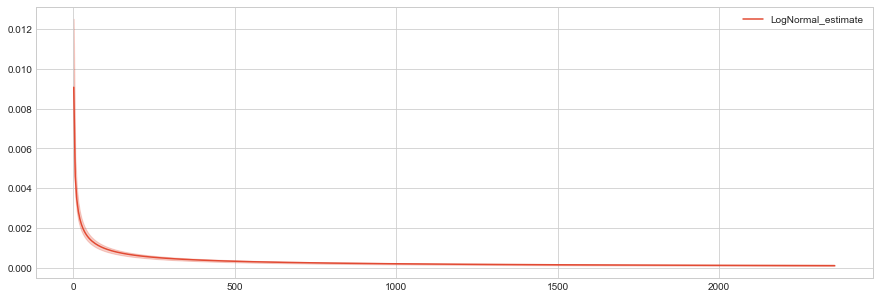

In [19]:
#let lifelines choose the best model out of the parametric models
best_model, best_aic_ = find_best_parametric_model(data['LENFOL'], data['FSTAT'], scoring_method="AIC")
print(best_model)
print(best_aic_)
#plot the hazard of the best model (Log Normal Fitter)
best_model.plot_hazard()

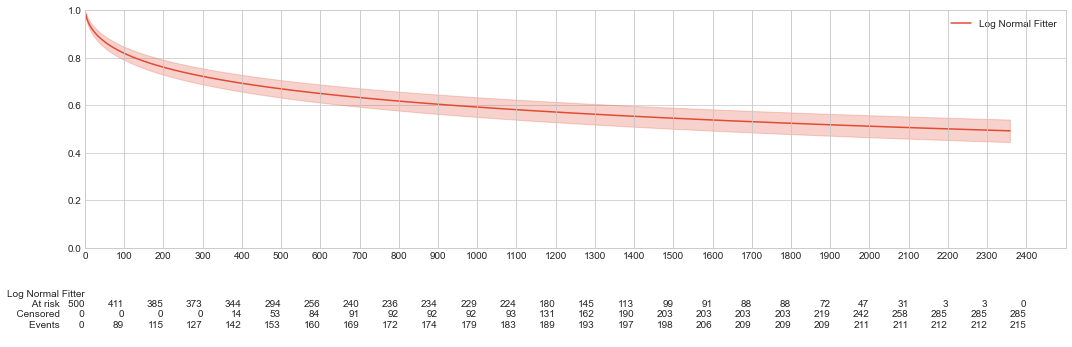

In [20]:
#fit and plot the basline survival curve of the fitted data with the Log Normal Model
lnf = LogNormalFitter()
lnf.fit(data['LENFOL'], event_observed=data['FSTAT'], label='Log Normal Fitter')

plt.axis([0,2500,0,1])
plt.xticks(np.arange(0, 2500, step=100))
lnf.plot_survival_function(at_risk_counts=True)
plt.grid(b=True, which='both')

Note that these two univariate models (Log Normal: parametric, Kaplan Meier: non-parametric) seem alike. The qq plot of the Log Normal Model was not as good as wanted though, which means the univariate models are not the best solution for this analysis either.

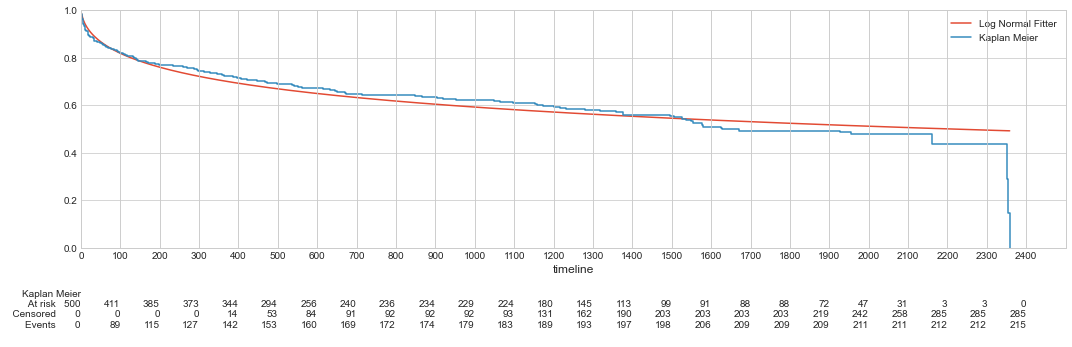

In [21]:
ax=lnf.plot_survival_function(at_risk_counts=False, ci_show=False)
plt.axis([0,2500,0,1])
plt.xticks(np.arange(0, 2500, step=100))
kmf.plot_survival_function(at_risk_counts=True, ax=ax, ci_show=False)
plt.grid(b=True, which='both')

#plt.savefig('Cox_lognormal.svg', transparent=True, bbox_inches='tight')

## Cox Probability Hazard Model

The Cox PH Fitter is a semi-parametric survival regression model, which firstly means it's a hybrid of both parametric and non-parametric models, and secondly it is multivariate and can deal with more attributes than just the event. This is the model we want to use and optimise.

In our first attempt we split up our data into train and test samples, which led to normal results. However lifelines provides an integrated cross_validation function to validate the model which we eventually used

In [22]:
#use data_train for train and data_test as a score method

#data2 = data.sample(frac=1, random_state=25367)

#data_train = data2.iloc[:450]
#data_test = data2.iloc[450:]


The Cox PH Fitter provides different options for the estimation method, penalization and stratification. Fortunately we don't need any penalty as the model has it's best scores without penalties.
The Cox Model fits the data with specified time and event columns and furthermore includes every other column.

In [23]:
Cox = CoxPHFitter(penalizer=0.0, l1_ratio=0.0)
Cox.fit(data, duration_col='LENFOL', event_col='FSTAT')
Cox.print_summary()

<lifelines.CoxPHFitter: fitted with 500 total observations, 285 right-censored observations>
             duration col = 'LENFOL'
                event col = 'FSTAT'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 215
   partial log-likelihood = -1127.44
         time fit was run = 2021-07-12 14:15:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGE         0.06       1.06       0.01             0.04             0.07                 1.04                 1.07
GENDER     -0.25       0.78       0.14            -0.53             0.03                 0.59                 1.03
HR          0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
DIASBP     -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
CHF         0.77       2.16       0.15             0.48             1.06                 1.62                 2.87

              z      p   -log2(p)
covariate                        
AGE        8.71 <0.005      58.16
GENDER    -1.73   0.08       3.58
HR         3.86 <0.005      13.11
DIASBP    -3.23 <0.005       9.68
CHF        5.23 <0.005      22.52
---
Concordance = 0.77
Partial AIC = 2264.89
log-likelihood ratio test = 199.75 on 5 df
-log2(p) of ll-ratio test = 134.52

The tables above show several evaluations of the model. (See documentation for a more detailed description)
The column exp(coef) gives the ratio of the influence of each attribute. This can be well intepreted for categorical attributes. For example, the value 0.78 for GENDER means, that the ratio of people having a 1/true (=female) in column GENDER with people having a 0/false (=male) is 0.78:1. This means that whenever "0.78" female persons die, then this is equivalent to 1 male person dying.

### Checking and validation of the model

The following built-in function of lifelines checks in several ways if the data fitted to the model + the model itself have no statistical semantic errors.
If any error occurs, lifelines shows you waht error happend, why it happend and gives links on how to solve these errors.
Note that this is not a direct validation of the model.

In [24]:
Cox.check_assumptions(data, show_plots=True)

Proportional hazard assumption looks okay.


[]

The following is a built-in cross validation of the model which uses the concordance index as the scoring method.
The result of .8 means that the model is almost overfitted, but it's just in the acceptable region. (use the penalizer and optionally the l1_ratio parameter in the fit above to handle overfitting)

In [25]:
scores = np.mean(k_fold_cross_validation(Cox, data, 'LENFOL', event_col='FSTAT', k=100, scoring_method="concordance_index"))
print(scores)

0.7954801587301588


The following is a built-in graphical method to see how good the model predicts the survival rate of data with a specified event-rate.
The more the red curve looks like the black one, the better the model. In this case the result is really good.

ICI =  0.013070767082751697
E50 =  0.014457868747542069


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 43 mortality'}, xlabel='Predicted probability of \nt ≤ 43 mortality', ylabel='Observed probability of \nt ≤ 43 mortality'>,
 0.013070767082751697,
 0.014457868747542069)

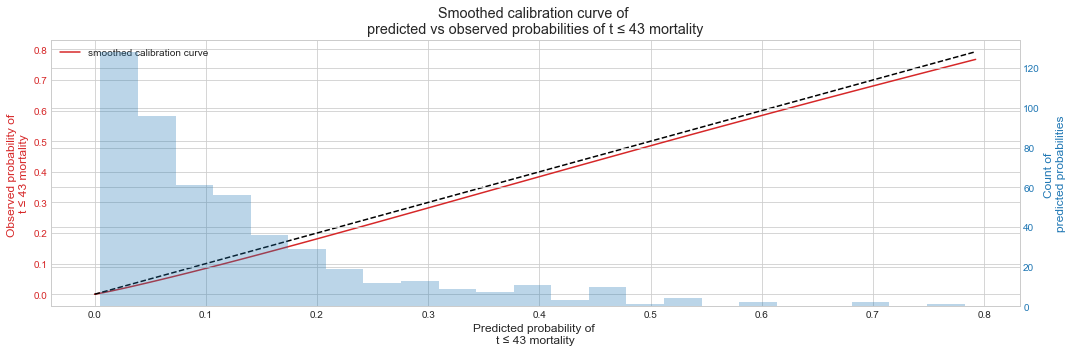

In [26]:
survival_probability_calibration(Cox, data, t0=43)
#plt.savefig('Test.svg', transparent=True, bbox_inches='tight')

### Survival graphs of Cox PH Model

The following shows the survival curve predicted by the Cox model.

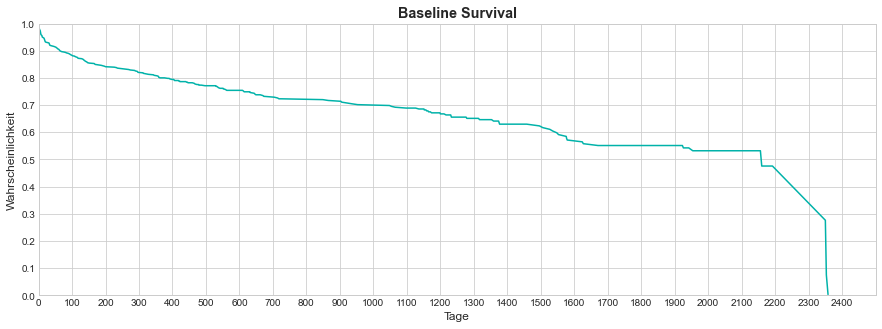

In [27]:
Cox.baseline_survival_.plot(color='#00b2a9',ls='-').legend('')

#this section of code is for configuration of the graphical output and is used in every other of the following code snippets
plt.axis([0,2500,0,1])
plt.title('Baseline Survival', fontweight='bold')
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
#plt.savefig('Baseline_Survival.svg', transparent=True, bbox_inches='tight')


The next graph shows the cumulated hazard and the hazard corresponding to the survival curve. (See documentationon for more a more detailed description)

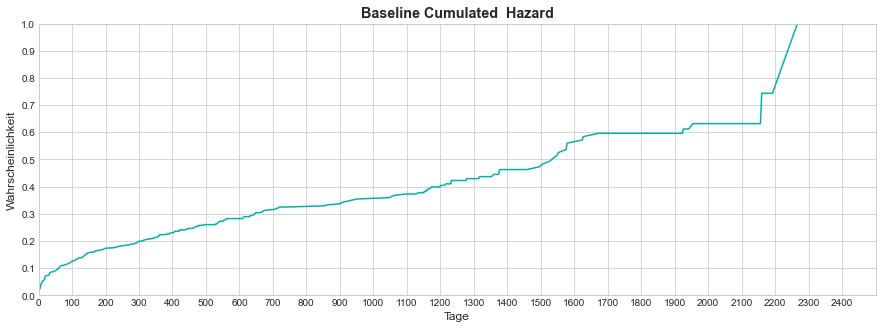

In [28]:
Cox.baseline_cumulative_hazard_.plot(color='#00b2a9',ls='-').legend('')

plt.axis([0,2500,0,1])
plt.title('Baseline Cumulated  Hazard', fontweight='bold')
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
#plt.savefig('Baseline_Cumulated.svg', transparent=True, bbox_inches='tight')


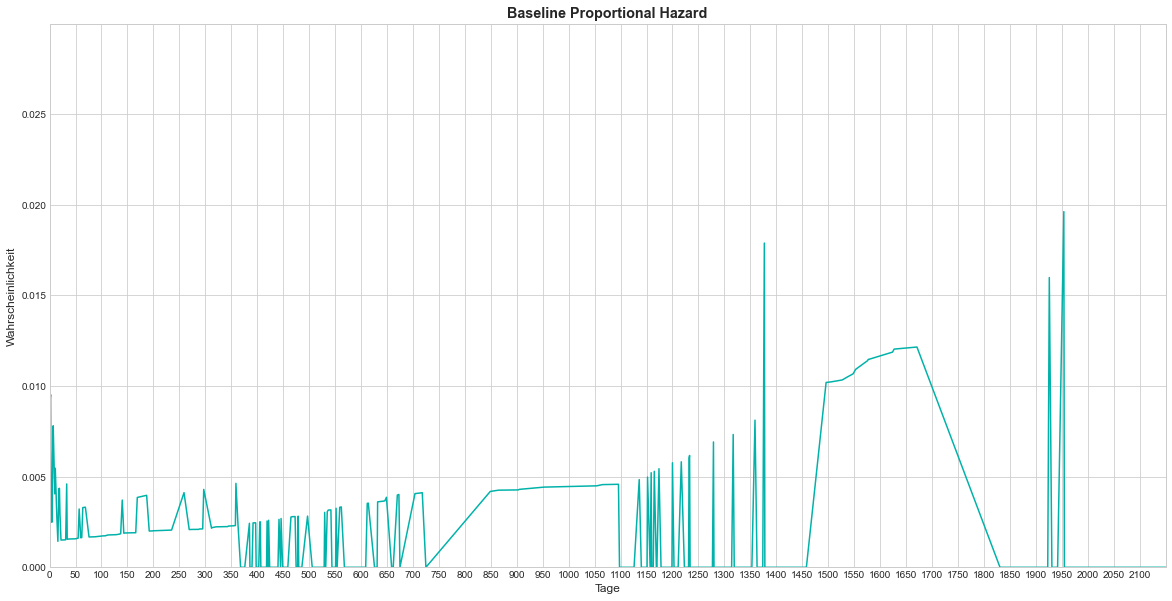

In [29]:
Cox.baseline_hazard_.plot(color='#00b2a9',ls='-', figsize=(20,10)).legend('')

plt.axis([0,2150,0,0.03])
plt.title('Baseline Proportional Hazard', fontweight='bold')
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.yticks(np.arange(0, 0.03, step=0.005))
plt.xticks(np.arange(0, 2150, step=50))
plt.grid(b=True, which='both')
#plt.savefig('Baseline_Hazard.svg', transparent=True, bbox_inches='tight')


### Impact of the attributes on the survival probability

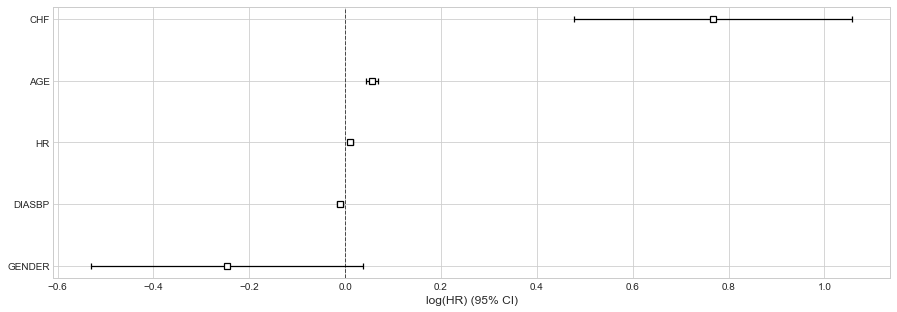

In [30]:
Cox.plot()
plt.grid(b=True, which='both', axis='x')
#plt.savefig('Variables.svg', transparent=True, bbox_inches='tight')

The graphic above shows the influence of each attribute on the probability. An attribute which is to the right of the dotted line means that this attribute has a negative impact on the survival probability.
In this case having a 1/True in the CHF attribute (which means that this person has the CHF illness) has a negative influence on the probability curve. A 1/True in GENDER (which means that the person is female) has a positive influence on the probability curve respectfully.

## Data Visualization

The following graphs show the influence of each of the used attributes. In most cases no further explanation is needed.
See the documentation on the critical interpretation for these graphs.

Text(0.5, 1.0, 'Geschlecht')

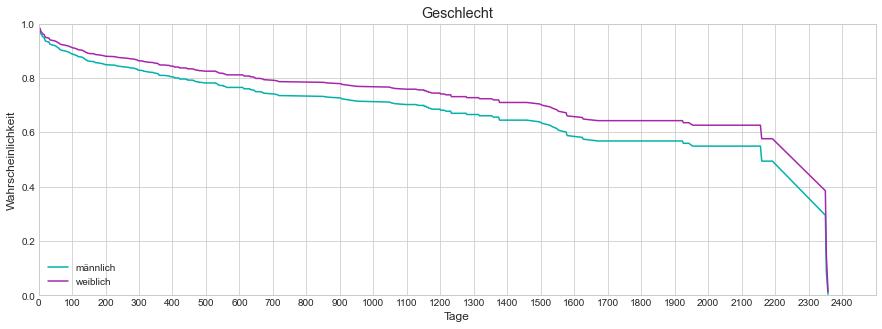

In [31]:
Cox.plot_partial_effects_on_outcome(covariates='GENDER', values=[0, 1], color=['#00b2a9','#a626aa'], plot_baseline=False, drawstyle='default').legend(['männlich','weiblich'], loc='lower left', bbox_to_anchor=(0,0))

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('Geschlecht')
#plt.savefig('Gender.svg', transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Alter')

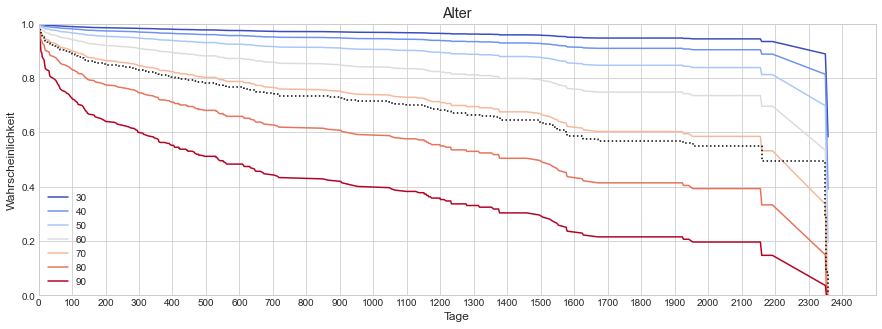

In [32]:
Cox.plot_partial_effects_on_outcome(covariates='AGE', values=[30, 40, 50, 60, 70, 80, 90], cmap='coolwarm', drawstyle='default').legend(['30', '40', '50', '60', '70', '80', '90'], loc='lower left',  bbox_to_anchor=(0,0))

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('Alter')
#plt.savefig('Age.svg', transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'CHF')

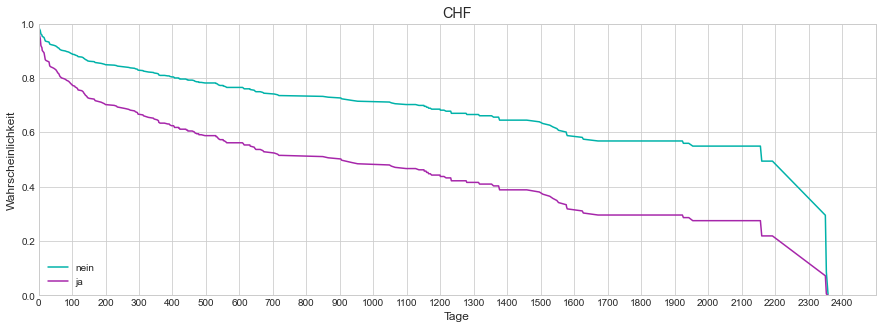

In [33]:
Cox.plot_partial_effects_on_outcome(covariates='CHF', values=[0, 1], color=['#00b2a9','#a626aa'], plot_baseline=False, drawstyle='default').legend(['nein','ja'], loc='lower left', bbox_to_anchor=(0,0))

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('CHF')
#plt.savefig('CHF.svg', transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Heartrate')

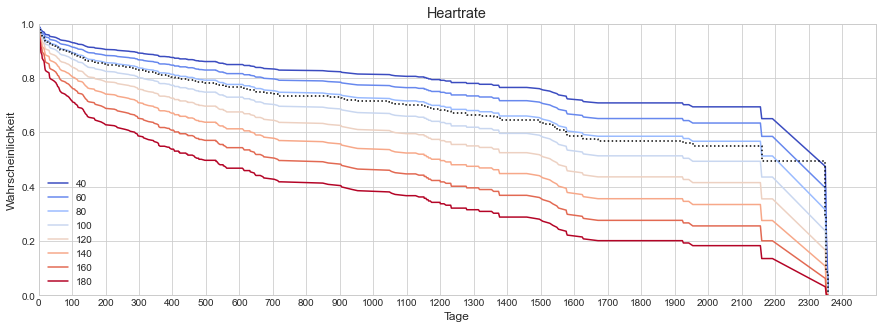

In [34]:
Cox.plot_partial_effects_on_outcome(covariates='HR', values=[40, 60, 80, 100, 120, 140, 160, 180], cmap='coolwarm', drawstyle='default').legend(['40', '60', '80', '100', '120', '140', '160', '180'], loc='lower left',  bbox_to_anchor=(0,0))

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('Heartrate')
#plt.savefig('HR.svg', transparent=True, bbox_inches='tight')

You can compare different combinations of attributes to see the outcome of the survival curve:

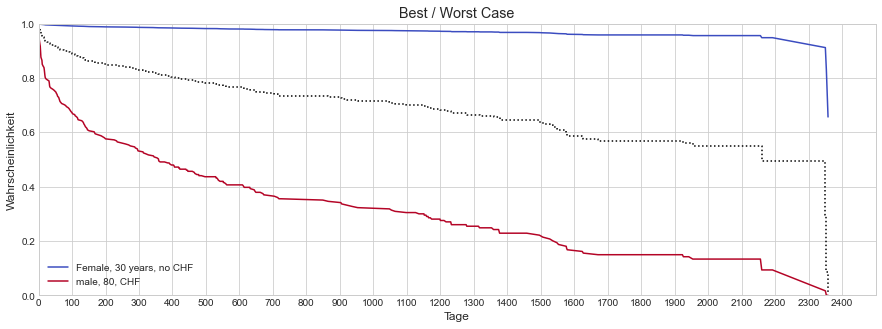

In [35]:
Cox.plot_partial_effects_on_outcome(covariates=['GENDER', 'AGE', 'CHF'], values=[[1,30,0],[0,80,1]], cmap='coolwarm', drawstyle='default').legend(['Female, 30 years, no CHF', 'male, 80, CHF'], loc='lower left',  bbox_to_anchor=(0,0))

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('Best / Worst Case')
#plt.savefig('best.svg', transparent=True, bbox_inches='tight')

### Prediction

This is what the model predicts on some random data:

In [37]:
t_data = data.iloc[30:35,]
t_data

,FSTAT,LENFOL,AGE,GENDER,HR,DIASBP,CHF
ID,,,,,,,
31,1,849,83,0,135,54,0
32,1,714,61,1,111,80,1
33,0,2057,58,1,86,103,1
34,1,2,90,1,97,82,0
35,1,7,84,1,69,76,1


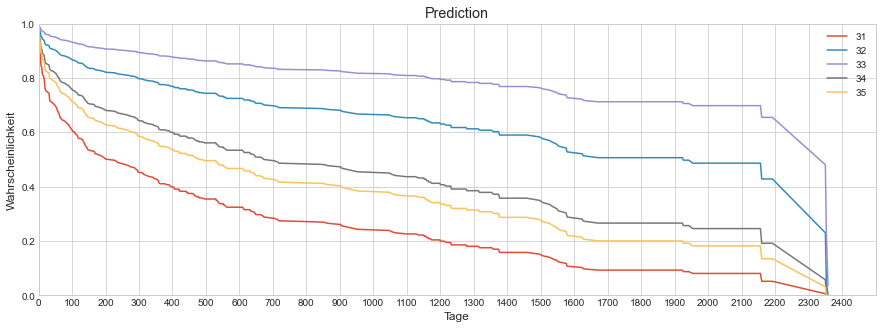

In [39]:
Cox.predict_survival_function(t_data).plot()

plt.axis([0,2500,0,1])
plt.xlabel('Tage')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(np.arange(0, 2500, step=100))
plt.grid(b=True, which='both')
plt.title('Prediction')
#plt.savefig('prediction.svg', transparent=True, bbox_inches='tight')